In [1]:
from BiasStudy import datasets, predictionKit
from BiasStudy.datasets import FairFaceDataset
from BiasStudy.config.TrainingConfig import BiasStudyConfig
from BiasStudy.trainingKit import TrainingLogger
from BiasStudy.trainingKit.TrainingModel import BiasModel

Python Platform: Linux-5.19.0-45-generic-x86_64-with-glibc2.35
Tensor Flow Version: 2.12.1
Keras Version: 2.12.0

Python 3.8.19 (default, Apr  6 2024, 17:58:10) 
[GCC 11.4.0]


In [2]:
import os
import sys
import platform
import numpy as np
import tensorflow as tf
import tensorflow.keras
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.models import Model
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten, Dense
import numpy as np
import pandas as pd

In [3]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load Models

In [4]:
RUN_ID = "c"

In [5]:
def get_run_description(run_id: str):  
    file_path = "/notebooks/code/training_workflow/layer_configs/run_{}/description.txt".format(run_id)

    with open(file_path, 'r') as file:
        file_content = file.read()

    print(file_content)

In [6]:
BASE_PATH_TO_WEIGHTS = "/notebooks/data/results/run_{0}/{1}_{2}/run_{0}_model_{1}conv_{2}kernel/model/model.h5"

def get_result_paths_dict(run_id: str) -> dict:
    get_run_description(RUN_ID)
    return {
        "8_3": BASE_PATH_TO_WEIGHTS.format(run_id, 8, 3),
        "8_5": BASE_PATH_TO_WEIGHTS.format(run_id, 8, 5),
        "16_3": BASE_PATH_TO_WEIGHTS.format(run_id, 16, 3),
        "16_5": BASE_PATH_TO_WEIGHTS.format(run_id, 16, 5)
    }

In [7]:
run_c_model_paths = get_result_paths_dict(RUN_ID)

* No flat 
* 30 epochs 
* 3 epoch patience
* No dropouts
* 0.0001 learning rate - Lower learning rate



In [8]:
def get_last_flat_layer_name(model: Model) -> str:
    last_layer_name = None
    for layer in model.layers:
        if type(layer) is Flatten:
            last_layer_name = layer.name
        if type(layer) is Dense and layer.units != 2:
            last_layer_name = layer.name
    return last_layer_name

In [9]:
def load_model_prep_for_bias_study(model_weight_path: str) -> Model:
    model = load_model(model_weight_path)
    embedding_layer = get_last_flat_layer_name(model)
    print("Embedding Layer: {}".format(embedding_layer))
    model.trainable = False
    return Model(
        inputs = model.input,
        outputs = model.get_layer(embedding_layer).output
    )

In [10]:
run_c_model_8_3 = load_model_prep_for_bias_study(run_c_model_paths["8_3"])
run_c_model_8_5 = load_model_prep_for_bias_study(run_c_model_paths["8_5"])
run_c_model_16_3 = load_model_prep_for_bias_study(run_c_model_paths["16_3"])
run_c_model_16_5 = load_model_prep_for_bias_study(run_c_model_paths["16_5"])

Embedding Layer: flatten
Embedding Layer: flatten
Embedding Layer: flatten
Embedding Layer: flatten


# Understand Model Training

In [11]:
BASE_PATH_TO_HISTORIES = "/notebooks/data/results/run_{0}/{1}_{2}/run_{0}_model_{1}conv_{2}kernel/csv_logging/logsrun_{0}_model_{1}conv_{2}kernel.csv"

def get_history_paths_dict(run_id: str) -> dict:
    return {
        "8_3": BASE_PATH_TO_HISTORIES.format(run_id, 8, 3),
        "8_5": BASE_PATH_TO_HISTORIES.format(run_id, 8, 5),
        "16_3": BASE_PATH_TO_HISTORIES.format(run_id, 16, 3),
        "16_5": BASE_PATH_TO_HISTORIES.format(run_id, 16, 5)
    }

In [12]:
def read_csv_history(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df[df.epoch != 'epoch']
    df = df.reset_index(drop=True)
    df['index'] = df.index
    df = df.loc[df.groupby("epoch")["index"].idxmax()]
    df = df.astype(float)
    df = df.sort_values(by=['epoch'], ascending=True)
    df = df.reset_index(drop=True)
    return df.copy()

In [13]:
run_c_history_paths = get_history_paths_dict(RUN_ID)

In [14]:
def plot_all(histories_dict):
    num_plots = len(histories_dict)
    f, axs = plt.subplots(1, num_plots, sharey=True, figsize=(num_plots * 5,  5))
    for idx, (key, history_path) in enumerate(histories_dict.items()):
        history = read_csv_history(history_path)
        axs[idx].plot(history.loss, label='training')
        axs[idx].plot(history.val_loss, label='validation')
        axs[idx].legend()
        axs[idx].set_title(key)
    plt.show()

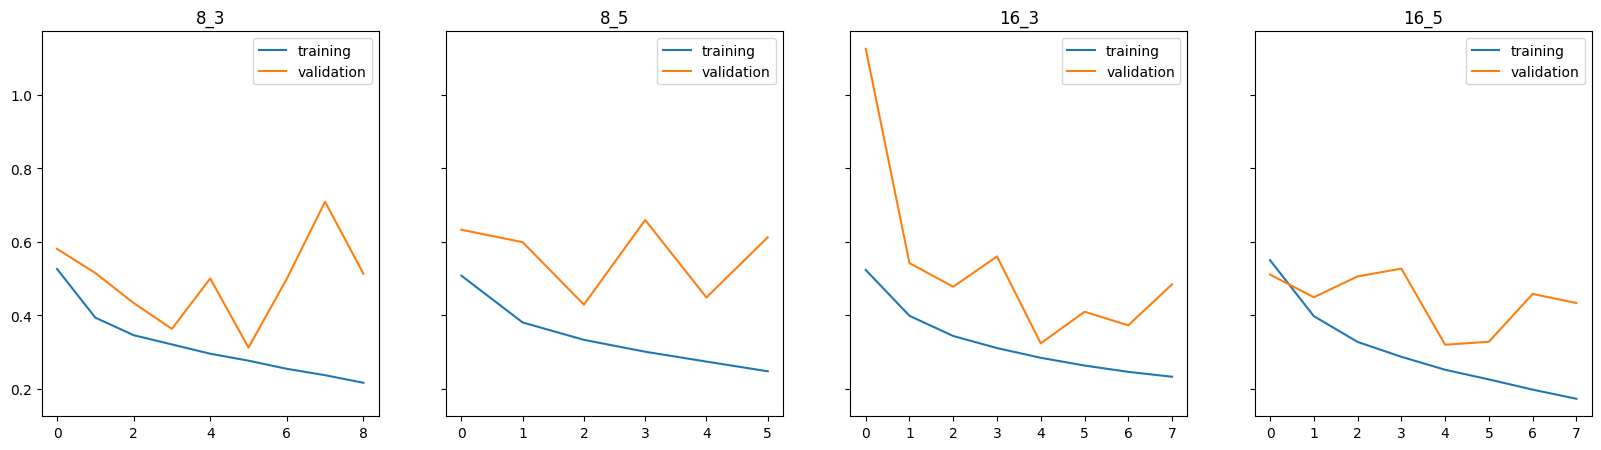

In [15]:
plot_all(run_c_history_paths)

# Load Dataset

In [16]:
IMAGE_DIR = "/notebooks/data/LFWA+/COMPILED/compiled_lfwa+"
BASE_DIR = "/notebooks/data/LFWA+/COMPILED"
ALL_PAIRS = "compiled_lfwa+_all_pairs.csv"

In [17]:
all_pairs =  pd.read_csv("{}/{}".format(BASE_DIR, ALL_PAIRS))

# Evaluation

## 8Layers - 3 Kernel Size

In [18]:
from BiasStudy.predictionKit import PredictionToolKit
from BiasStudy.predictionKit import PredictionPlotKit

In [19]:
run_c_model_8_3_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_c_model_8_3,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [20]:
print(run_c_model_8_3_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 46.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.479947650668763 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.641981272294887 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.155172413793103 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.172413793103448 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 22.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.503659192364057 |
+-------

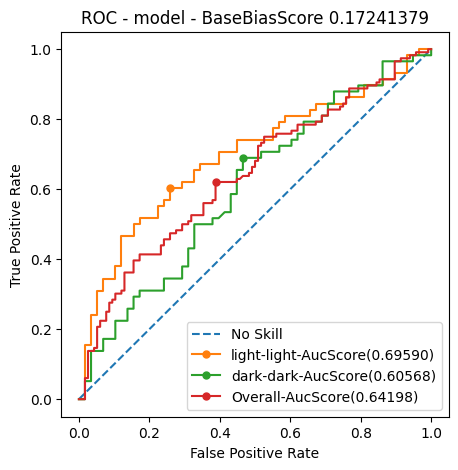

In [21]:
PredictionPlotKit.plot_roc(run_c_model_8_3_bias_result)

## 8Layers - 5 Kernel Size

In [22]:
run_c_model_8_5_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_c_model_8_5,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [23]:
print(run_c_model_8_5_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 50.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.425095355363966 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.647034780023781 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.120689655172414 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.137931034482759 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 24.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.433616683805080 |
+-------

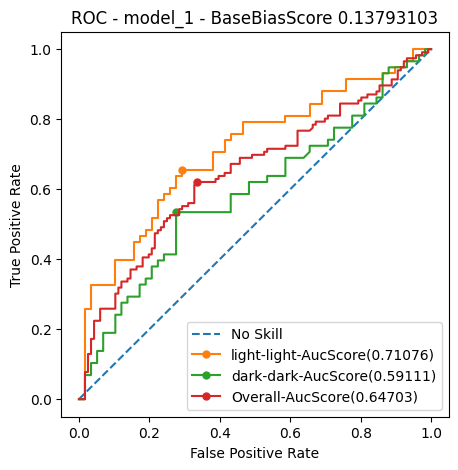

In [24]:
PredictionPlotKit.plot_roc(run_c_model_8_5_bias_result)

## 16Layers - 3 Kernel Size

In [25]:
run_c_model_16_3_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_c_model_16_3,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [26]:
print(run_c_model_16_3_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 53.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.951715607988269 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.517650118906064 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.068965517241379 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.120689655172414 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 23.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.965671016390714 |
+-------

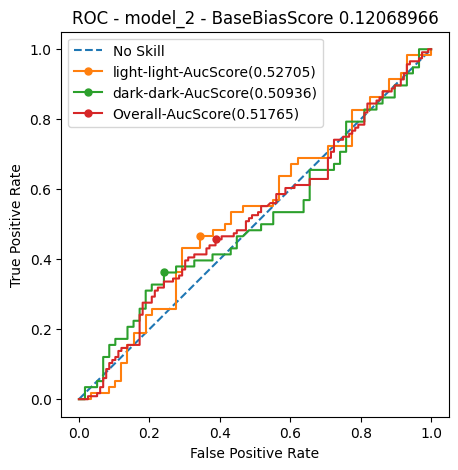

In [27]:
PredictionPlotKit.plot_roc(run_c_model_16_3_bias_result)

## 16Layers - 5Kernel Size

In [28]:
run_c_model_16_5_bias_result = PredictionToolKit.predict(
    feature_name = 'binary_race',
    unique_image_id_col_name = 'image_id',
    file_path_col_name = 'file_path',
    pair_id_col_name = 'gid',
    y_col = 'y_match_per_group',
    image_dir = IMAGE_DIR,
    dataset = all_pairs,
    model = run_c_model_16_5,
    verbose = 0, 
    best_threshold_method = 'gmeans'
)

........................................................................................................................................................................................................................................

In [29]:
print(run_c_model_16_5_bias_result)

+-------------+------------------------+--------------------+
| Variation   | Metric Name            |              Value |
+=============+========================+====================+
| OverAll     | Best Threshold IDX     | 66.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Best Threshold         |  0.877314211256797 |
+-------------+------------------------+--------------------+
| OverAll     | AUC Score              |  0.550274970273484 |
+-------------+------------------------+--------------------+
| OverAll     | Bias At Best Threshold |  0.000000000000000 |
+-------------+------------------------+--------------------+
| OverAll     | Base Bias at 0.1 FPR   |  0.051724137931034 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold IDX     | 40.000000000000000 |
+-------------+------------------------+--------------------+
| light-light | Best Threshold         |  0.858232338534798 |
+-------

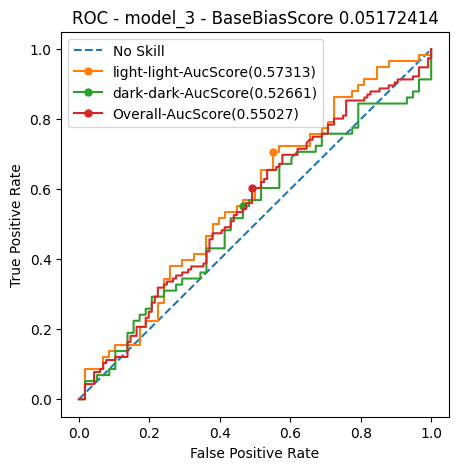

In [30]:
PredictionPlotKit.plot_roc(run_c_model_16_5_bias_result)

## ALL

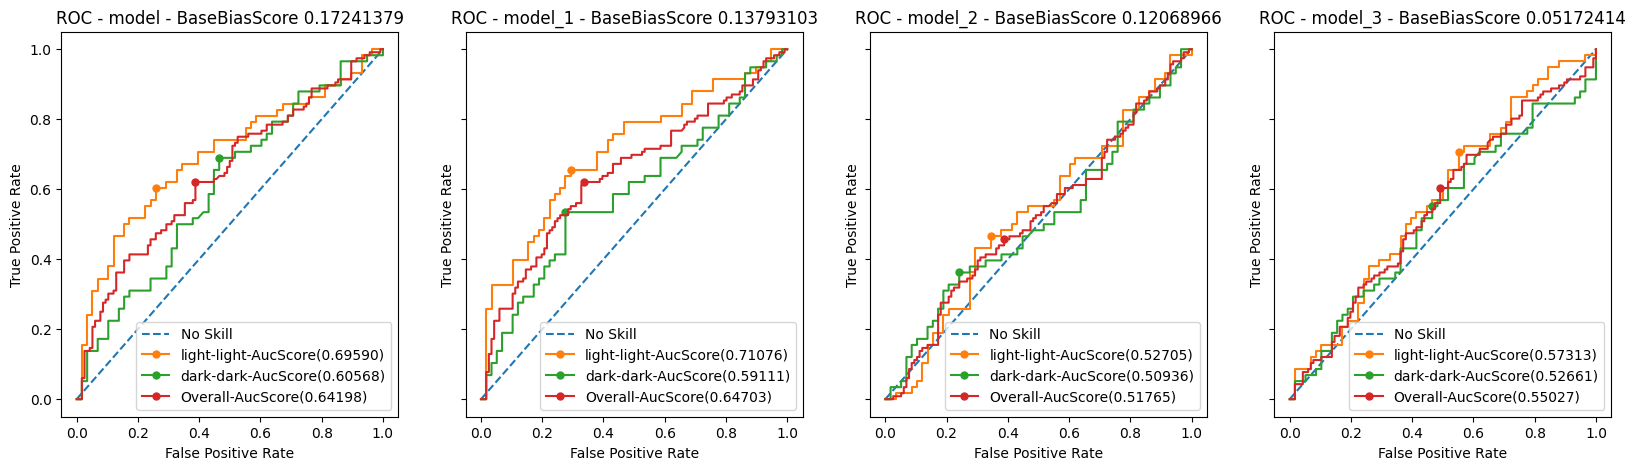

In [31]:
PredictionPlotKit.plot_multiple_roc(
    [
        run_c_model_8_3_bias_result,
        run_c_model_8_5_bias_result,
        run_c_model_16_3_bias_result,
        run_c_model_16_5_bias_result
    ]
)